In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel_h,sobel_v,gaussian
import cv2
import math
%matplotlib inline



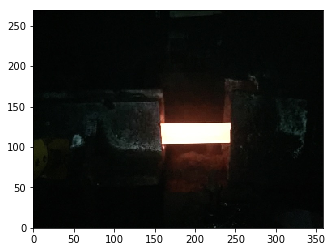

In [2]:
img_raw = plt.imread('./data/r3.jpg')
img_raw = img_raw[::2, ::2]
h, w = np.shape(img_raw)[:2]
plt.imshow(img_raw, extent=(0,w,0,h))

C:\Users\CYH\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


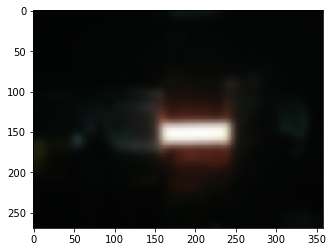

In [3]:
img_blur = gaussian(img_raw,5)
plt.imshow(img_blur)

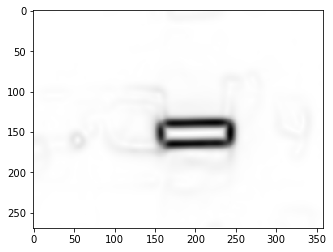

In [4]:
def sobel(img):
    components = []
    for c in range(np.shape(img)[-1]):
        components.append(sobel_h(img[:,:,c]))
        components.append(sobel_v(img[:,:,c]))
    components = np.array(components)
    edge = np.sqrt(np.sum(np.square(components),0))
    return edge

edges = sobel(img_blur)
plt.imshow(edges,cmap='Greys')

(0, 269)

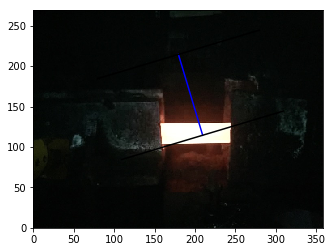

In [5]:
def plot_ruler(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    plt.plot((x1+0.5,x2+0.5),(y1+0.5,y2+0.5),color='blue')
    
    y11 = y1-(x2-x1)
    y12 = y1+(x2-x1)
    x11 = x1+(y2-y1)
    x12 = x1-(y2-y1)
    plt.plot((x11+0.5,x12+0.5),(y11+0.5,y12+0.5),color='black')
    
    y21 = y2-(x2-x1)
    y22 = y2+(x2-x1)
    x21 = x2+(y2-y1)
    x22 = x2-(y2-y1)
    plt.plot((x21+0.5,x22+0.5),(y21+0.5,y22+0.5),color='black')

p1 = np.array([w//2, h//2+80],np.float) 
p2 = np.array([w//2+30, h//2-20],np.float)
plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)


In [6]:
ps = np.stack(np.meshgrid(np.arange(w),np.flip(np.arange(h))),-1)

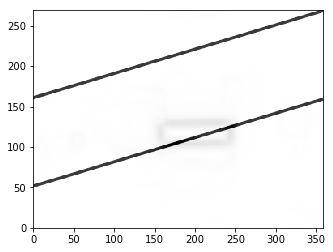

In [7]:
def lines_mask(p1,p2,ps,thickness=5):
    n = p2-p1
    n = n/np.sqrt(np.sum(np.square(n),-1))
    
    d1 = np.abs(np.sum((ps-p1)*n,-1))
    d2 = np.abs(np.sum((ps-p2)*n,-1))
    
    line1 = np.clip(thickness/2-d1,0.0,1.0)
    line2 = np.clip(thickness/2-d2,0.0,1.0)
    
    return line1, line2

line1, line2 = lines_mask(p1,p2,ps,thickness=5)
plt.imshow(line1+line2+edges, extent=(0,w,0,h),cmap="Greys")


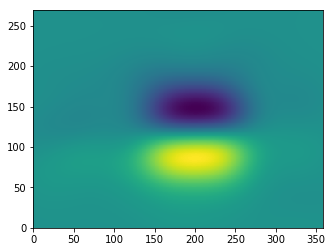

In [8]:
edges_blur = gaussian(edges,25)
grad = np.stack([sobel_v(edges_blur),-sobel_h(edges_blur)],-1)

plt.imshow(grad[...,1], extent=(0,w,0,h))

In [9]:
def compute_pan(grad,mask):
    mask = np.expand_dims(mask,-1)
    pan = np.sum(grad * mask,(0,1))
    return pan
    
mask = np.any([line1,line2],0)
compute_pan(grad,mask)

array([-0.1079301 ,  0.33455602])

In [10]:
def compute_rot(pc,ps,grad,mask):
    pd = ps-pc
    rot = np.cross(grad,pd)
    # plt.imshow(rot,extent=(0,w,0,h))
    rot = np.sum(rot*mask,(0,1))
    return rot

compute_rot((p1+p2)/2,ps,grad,mask)

34.21666226941351

In [11]:
def dp_by_rot(p,rot):
    rm = np.array([
        [np.cos(rot),-np.sin(rot)],
        [np.sin(rot),np.cos(rot)]
    ])
    return np.dot(p,rm) - p

In [12]:
def compute_spring(p1,p2,lower=None,upper=None,rebound=0.0):
    if upper is None:
        upper = lower
    
    l = np.sqrt(np.sum(np.square(p1-p2)))
    if lower is not None:
        dl_lower = lower - l
        if dl_lower > 0:
            dp1 = (p1-p2) * (dl_lower+rebound)
            dp2 = -dp1
            return dp1, dp2
    elif upper is not None:
        dl_upper = l - upper
        if dl_upper > 0:
            dp1 = (p2-p1) * (dl_upper+rebound)
            dp2 = -dp1
            return dp1, dp2
    return np.zeros(2,np.float), np.zeros(2,np.float)

In [13]:
def compute_score(mask,edges):
    score = np.mean(mask * edges)
    return score

(0, 269)

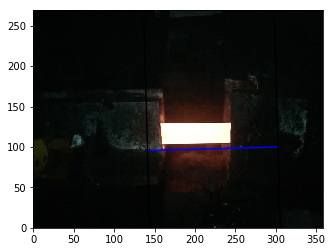

In [14]:
h, w = np.shape(edges)
p1 = np.array([w//2, h//2+50],np.float)+np.random.normal(0,60,2)
p2 = np.array([w//2, h//2-50],np.float)+np.random.normal(0,60,2)

v1 = np.zeros(2,np.float)
v2 = np.zeros(2,np.float)

scores = []
movements = []

plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

step=1 score=1.9242217353782065
step=2 score=2.077403957288454
step=3 score=2.3384305413148656
step=4 score=2.6472503302287405
step=5 score=2.927177377143072
step=6 score=3.1285284850488257
step=7 score=3.253634909462779
step=8 score=3.3309314815444107
step=9 score=3.3873391544967437
step=10 score=3.4419789770097977
step=11 score=3.510280122097741
step=12 score=3.6081627236110934
step=13 score=3.755436058545406
step=14 score=3.977343338767547
step=15 score=4.298027516155848
step=16 score=4.714117460723588
step=17 score=4.56631824137324
step=18 score=4.563913577528616
step=19 score=4.709643369772361
step=20 score=4.964690434056103
step=21 score=5.2435112540753614
step=22 score=5.472638087775584
step=23 score=5.083105214492278
step=24 score=4.872566659297086
step=25 score=4.882059679353337
step=26 score=5.044607940501551
step=27 score=5.270014327472444
step=28 score=5.484724587918605
step=29 score=5.063181251333115
step=30 score=4.818644172455355
step=31 score=4.813300792811978
step=32 s

(0, 269)

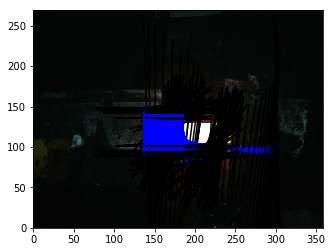

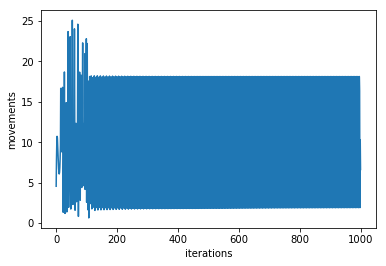

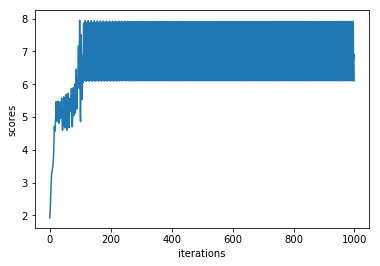

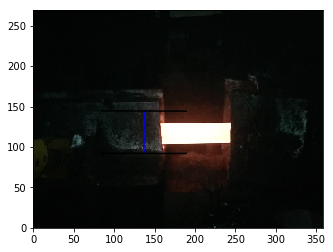

In [15]:
plt.imshow(img_raw, extent=(0,w,0,h))
plt.xlim(0,w)
plt.ylim(0,h)

decent_rate = 1
momentum = 1
damping = 0.3

length = np.sqrt(w*h)
thickness = 5

pan_m = 0.0001*length*thickness
rot_m = 0.002*length*length*thickness
spr_m = 0.1*length

plot_ruler(p1,p2)

mask1, mask2 = lines_mask(p1,p2,ps,thickness)
mask_all = mask1+mask2

for i in range(1000):
    mask1, mask2 = lines_mask(p1,p2,ps,thickness)
    mask_all = mask1+mask2
    
    pc = (p1+p2)/2
    
    dp1 = 0
    dp2 = 0
    
    pan1 = compute_pan(grad,mask1) / pan_m
    pan2 = compute_pan(grad,mask2) / pan_m
    # print(pan1,pan2)
    dp1 += pan1
    dp2 += pan2
    
    rot = compute_rot(pc,ps,grad,mask_all) / rot_m
    dp1 += dp_by_rot(p1-pc,rot)
    dp2 += dp_by_rot(p2-pc,rot)
    # print(dp_by_rot(p1-pc,rot),dp_by_rot(p2-pc,rot))

    spring1, spring2 = compute_spring(p1,p2,50,150,10)
    dp1 += spring1 / spr_m
    dp2 += spring2 / spr_m
    # print(spring1 / spr_m,spring2 / spr_m)
    
    # print(dp1,dp2)
    
    # v1 = dp1*decent_rate/momentum
    # v2 = dp2*decent_rate/momentum
    
    v1 += dp1*decent_rate/momentum
    v2 += dp2*decent_rate/momentum
    
    v1 *= 1.0-damping
    v2 *= 1.0-damping
    
    p1 += v1
    p2 += v2
    
    movement = np.sqrt(np.sum(np.square(v1))) + np.sqrt(np.sum(np.square(v2)))
    movements.append(movement)
    
    score = compute_score(mask_all,edges_blur)*(10**4)
    # score = compute_score(mask_all,edges)
    scores.append(score)
    
    # print(f"step={len(movements)}, movement={movement:.2f}, score={score:.2f}")
    print('step={}'.format(len(movements), 'movement={}'.format(movement)), 'score={}'.format(score))
    plot_ruler(p1,p2)
    
    if len(movements)>5:
        if movements[-1]<0.5:
            last_movements = np.array(movements[-5:])
            mean = np.mean(last_movements)
            std_dev = np.sqrt(np.mean(np.square(last_movements-mean)))
            if std_dev/mean <= 0.01:
                break

plt.figure()
plt.plot(movements)
plt.ylabel("movements")
plt.xlabel("iterations")

plt.figure()
plt.plot(scores)
plt.ylabel("scores")
plt.xlabel("iterations")

plt.figure()
plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

In [20]:
def gradientDescent(img_path, p1, p2):
    img_raw = plt.imread(img_path)
    img_raw = img_raw[::2, ::2]
    h, w = np.shape(img_raw)[:2]
    img_blur = gaussian(img_raw,5)
    edges = sobel(img_blur)
    ps = np.stack(np.meshgrid(np.arange(w),np.flip(np.arange(h))),-1)
    line1, line2 = lines_mask(p1,p2,ps,thickness=5)
    edges_blur = gaussian(edges,25)
    grad = np.stack([sobel_v(edges_blur),-sobel_h(edges_blur)],-1)
    
    v1 = np.zeros(2,np.float)
    v2 = np.zeros(2,np.float)
    
    scores = []
    movements = []
    
    decent_rate = 1
    momentum = 1
    damping = 0.3
    
    length = np.sqrt(w*h)
    thickness = 5
    
    pan_m = 0.0001*length*thickness
    rot_m = 0.002*length*length*thickness
    spr_m = 0.1*length
    
    plot_ruler(p1,p2)
    
    
    for i in range(100):
        mask1, mask2 = lines_mask(p1,p2,ps,thickness)
        mask_all = mask1+mask2
        
        pc = (p1+p2)/2
        
        dp1 = 0
        dp2 = 0
        
        pan1 = compute_pan(grad,mask1) / pan_m
        pan2 = compute_pan(grad,mask2) / pan_m
        # print(pan1,pan2)
        dp1 += pan1
        dp2 += pan2
        
        rot = compute_rot(pc,ps,grad,mask_all) / rot_m
        dp1 += dp_by_rot(p1-pc,rot)
        dp2 += dp_by_rot(p2-pc,rot)
        # print(dp_by_rot(p1-pc,rot),dp_by_rot(p2-pc,rot))
    
        spring1, spring2 = compute_spring(p1,p2,50,150,10)
        dp1 += spring1 / spr_m
        dp2 += spring2 / spr_m
        # print(spring1 / spr_m,spring2 / spr_m)
        
        # print(dp1,dp2)
        
        # v1 = dp1*decent_rate/momentum
        # v2 = dp2*decent_rate/momentum
        
        v1 += dp1*decent_rate/momentum
        v2 += dp2*decent_rate/momentum
        
        v1 *= 1.0-damping
        v2 *= 1.0-damping
        
        p1 += v1
        p2 += v2
        
        movement = np.sqrt(np.sum(np.square(v1))) + np.sqrt(np.sum(np.square(v2)))
        movements.append(movement)
        
        score = compute_score(mask_all,edges_blur)*(10**4)
        # score = compute_score(mask_all,edges)
        scores.append(score)
        
        # print(f"step={len(movements)}, movement={movement:.2f}, score={score:.2f}")
        print('step={}'.format(len(movements), 'movement={}'.format(movement)), 'score={}'.format(score))
        plot_ruler(p1,p2)
        
        if len(movements)>5:
            if movements[-1]<0.5:
                last_movements = np.array(movements[-5:])
                mean = np.mean(last_movements)
                std_dev = np.sqrt(np.mean(np.square(last_movements-mean)))
                if std_dev/mean <= 0.01:
                    break
    
    plt.figure()
    plt.plot(movements)
    plt.ylabel("movements")
    plt.xlabel("iterations")
    
    plt.figure()
    plt.plot(scores)
    plt.ylabel("scores")
    plt.xlabel("iterations")
    
    plt.figure()
    plt.imshow(img_raw, extent=(0,w,0,h))
    plot_ruler(p1,p2)
    plt.xlim(0,w)
    plt.ylim(0,h)

In [22]:
img_raw = plt.imread('./data/lab1.jpg')
img_raw = img_raw[::2, ::2]
h, w = np.shape(img_raw)[:2]
p1 = np.array([w//2, h//2+50],np.float)+np.random.normal(0,60,2)
p2 = np.array([w//2, h//2-50],np.float)+np.random.normal(0,60,2)

C:\Users\CYH\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


step=1 score=2.227138337022167
step=2 score=2.263011713226467
step=3 score=2.3913276060973474
step=4 score=2.3544209585755724
step=5 score=2.392954651702464
step=6 score=2.424652166198939
step=7 score=2.4213449420631887
step=8 score=2.4855108069902236
step=9 score=2.4851715422528105
step=10 score=2.519490380196618
step=11 score=2.526759375699738
step=12 score=2.529418675221452
step=13 score=2.5373959685634278
step=14 score=2.5338588902675268
step=15 score=2.5364319202060375
step=16 score=2.541123980295285
step=17 score=2.5442869888799975
step=18 score=2.5497321204618784
step=19 score=2.5529074799234523
step=20 score=2.555687778408117
step=21 score=2.5581265334410226
step=22 score=2.560420876809935
step=23 score=2.5634450008304035
step=24 score=2.5661185681486116
step=25 score=2.568729334261914
step=26 score=2.5710402735558255
step=27 score=2.573416760618505
step=28 score=2.5756929226543366
step=29 score=2.57781147002896
step=30 score=2.5797963637935815
step=31 score=2.581711645238118
s

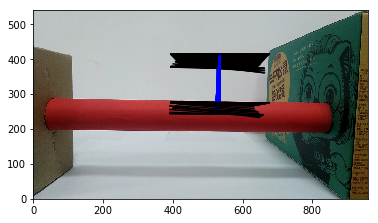

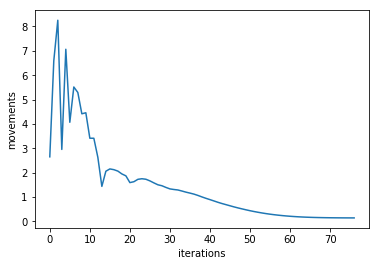

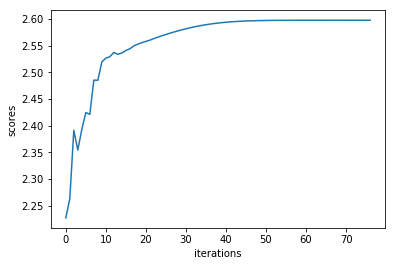

In [23]:
gradientDescent('./data/lab1.jpg', p1, p2)